In [31]:
import pandas as pd
import numpy as np


In [32]:
df=pd.read_csv('/content/drive/MyDrive/Data Analysis Projects For Resume/Sales Forecasting & Market Basket Analysis/online_retail_II.csv',encoding='ISO-8859-1')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB




```
You should see columns like:

Invoice – transaction number

StockCode – product code

Description – product name

Quantity – number of items sold

InvoiceDate – date and time of transaction

Price or UnitPrice – price per item

Customer ID – customer number

Country – location


```



**Check for Missing Values**

In [34]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0




```
Drop Missing or Incomplete Rows
```



In [35]:
df = df.dropna(subset=['Customer ID', 'Description'])

**Remove Canceled Orders**

In [36]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df = df[df['Quantity'] > 0]


**Convert InvoiceDate to DateTime**

In [37]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

**Create Total Sales Column**

In [38]:
df['TotalSales'] = df['Quantity'] * df['Price']

**Check for Duplicates**

In [39]:
df.duplicated().sum()
df = df.drop_duplicates()


**EDA (Exploratory Data Analysis)**

In [40]:
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalSales'].sum().reset_index()
daily_sales.columns = ['Date', 'TotalSales']


In [41]:
# Save the cleaned DataFrame to a CSV file
df.to_csv('cleaned_online_retail_data.csv', index=False)  # 'index=False' prevents saving the index

# Download the CSV file
from google.colab import files
files.download('cleaned_online_retail_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**📈 Total Sales Over Time**

In [42]:
import plotly.express as px

# Interactive Line Chart with Plotly
fig = px.line(
    daily_sales,
    x='Date',
    y='TotalSales',
    title='🕒 Total Sales Over Time (Interactive)',
    labels={'Date': 'Date', 'TotalSales': 'Total Sales'},
    template='plotly_white'
)

fig.update_traces(line=dict(color='royalblue'))
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Total Sales',
    hovermode='x unified'
)

fig.show()


**Top 10 Selling Products**

In [43]:
import plotly.express as px

# Prepare data for Plotly
top_products = df.groupby('Description')['TotalSales'] \
                 .sum().sort_values(ascending=False).head(10).reset_index()

# Create interactive bar chart
fig = px.bar(
    top_products,
    x='Description',
    y='TotalSales',
    title='🏆 Top 10 Selling Products',
    labels={'Description': 'Product', 'TotalSales': 'Total Sales'},
    template='plotly_white',
    color='TotalSales',
    color_continuous_scale='Blues'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()


**Forecasting with Prophet**

In [44]:
!pip install prophet
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')



```
Prepare Data for Prophet
```



In [45]:
df_prophet = daily_sales.rename(columns={"Date": "ds", "TotalSales": "y"})



```
Fit the Model
```



In [46]:
model=Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp291p0mn_/wti87pmb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp291p0mn_/42oljw87.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28893', 'data', 'file=/tmp/tmp291p0mn_/wti87pmb.json', 'init=/tmp/tmp291p0mn_/42oljw87.json', 'output', 'file=/tmp/tmp291p0mn_/prophet_model8gvmtijo/prophet_model-20250404132858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:28:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:28:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




```
Create Future Dates & Predict
```



In [47]:
future = model.make_future_dataframe(periods=90)  # Forecast 90 days
forecast = model.predict(future)



```
Visualize Forecast
```



In [48]:
import plotly.graph_objects as go

# Create an interactive figure
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(
    x=df_prophet['ds'],
    y=df_prophet['y'],
    mode='lines',
    name='Actual Sales',
    line=dict(color='royalblue')
))

# Forecasted data
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Forecast',
    line=dict(color='orange')
))

# Add upper and lower bounds
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    name='Upper Bound',
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    mode='lines',
    name='Lower Bound',
    fill='tonexty',
    fillcolor='rgba(255,165,0,0.2)',
    line=dict(width=0),
    showlegend=True
))

# Customize layout
fig.update_layout(
    title='📈 Sales Forecast (Next 3 Months)',
    xaxis_title='Date',
    yaxis_title='Sales',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()


**Forecast Components**

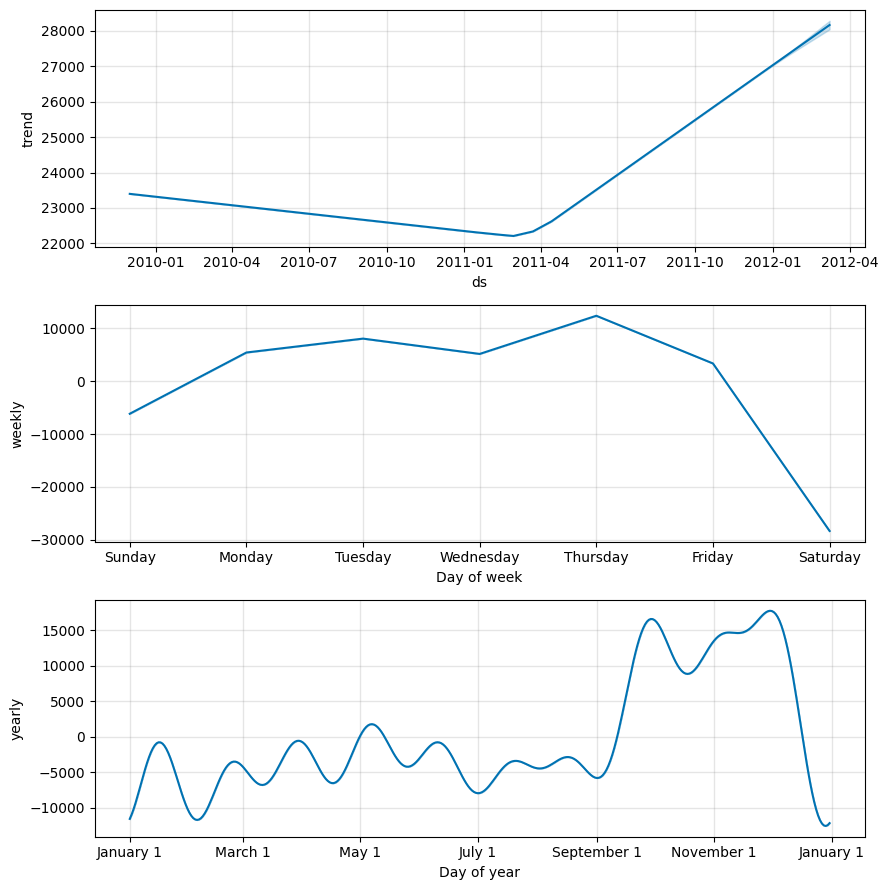

In [49]:
import matplotlib.pyplot as plt
model.plot_components(forecast)
plt.show()



```
Nice! The model.plot_components(forecast) command shows Prophet's breakdown of trends, like:

📈 Overall trend (is sales increasing or decreasing over time?)

📆 Weekly seasonality (do sales spike on certain days of the week?)

🗓️ Yearly seasonality (if applicable — though some datasets may not show this if under 1 year)
```



**Market Basket Analysis**



```
Prepare Transaction Data
```



In [50]:
# Filter for one country (e.g., UK)
basket_df = df[df['Country'] == 'United Kingdom']

# Group by Invoice and Description
basket = basket_df.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().fillna(0)

# Convert to 1s and 0s (binary)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)


**Apply Apriori Algorithm**

In [51]:
from mlxtend.frequent_patterns import apriori, association_rules

# Get frequent itemsets
frequent_items = apriori(basket, min_support=0.02, use_colnames=True)

# Generate rules
rules = association_rules(frequent_items, metric="lift", min_threshold=1)
rules.sort_values('confidence', ascending=False).head(10)


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
12,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.046205,0.140136,0.032612,0.705806,5.036584,1.0,0.026137,2.922784,0.840278,0.212139,0.657860,0.469261
15,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.032701,0.049395,0.022536,0.689152,13.951902,1.0,0.020921,3.058105,0.959709,0.378378,0.673000,0.572699
16,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.048024,0.051243,0.028975,0.603352,11.774313,1.0,0.026514,2.391936,0.961231,0.412214,0.581929,0.584398
17,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.051243,0.048024,0.028975,0.565445,11.774313,1.0,0.026514,2.190693,0.964493,0.412214,0.543523,0.584398
2,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.043105,0.052704,0.022775,0.528354,10.024981,1.0,0.020503,2.008490,0.940802,0.311837,0.502114,0.480240
0,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.051303,0.051571,0.025487,0.496804,9.633406,1.0,0.022842,1.884811,0.944658,0.329353,0.469443,0.495512
1,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.051571,0.051303,0.025487,0.494220,9.633406,1.0,0.022842,1.875710,0.944925,0.329353,0.466869,0.495512
5,(JUMBO BAG STRAWBERRY),(JUMBO BAG RED RETROSPOT),0.043075,0.071275,0.020807,0.483045,6.777176,1.0,0.017737,1.796529,0.890818,0.222435,0.443371,0.387487
14,(STRAWBERRY CERAMIC TRINKET BOX),(SWEETHEART CERAMIC TRINKET BOX),0.049395,0.032701,0.022536,0.456246,13.951902,1.0,0.020921,1.778928,0.976562,0.378378,0.437864,0.572699
10,(LUNCH BAG SPACEBOY DESIGN ),(LUNCH BAG BLACK SKULL.),0.050051,0.056698,0.021791,0.435378,7.678863,1.0,0.018953,1.670679,0.915599,0.256491,0.401441,0.409855


**Visualize Association Rules**

In [53]:
import plotly.express as px

# Top 10 rules
top_rules = rules.sort_values('lift', ascending=False).head(10)

# Convert frozenset to string for visualization
top_rules['antecedents'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
top_rules['consequents'] = top_rules['consequents'].apply(lambda x: ', '.join(list(x)))

fig = px.scatter(
    top_rules,
    x='support',
    y='confidence',
    size='lift',
    color='lift',
    hover_data=['antecedents', 'consequents'],
    title='🧠 Association Rules (Top 10)'
)
fig.show()